In [1]:
import pandas as pd
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
import math

We want to size the HP based on the demand and the outdoor temperature. The sizing is based on the Appendix A and C of The Reference Framework for System Simulations of the IEA SHC Task 44 / HPP Annex 38 Part B: Buildings and Space Heat Load. Once the heat pump size is known, the heating system' supply and return temperatures for the three types of houses are calculated for space heating and domestic hot water. Finally, the COP is calculated for the distribution temperature and the output temperature

In [2]:
import pickle
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
test_dict=load_obj('../Input/test')

In [4]:
test_dict['26930(Building-902138-CH895237183088)']['temperature'].to_csv('temp.csv')

In [5]:
sample_profile = next(iter(test_dict))


In [6]:
print(test_dict[sample_profile]['Qs'].sum())

15468.125


The Qs is already in kWh, see extract_inputs.py

In [7]:
test_dict.keys()

dict_keys(['26930(Building-902138-CH895237183088)', '26931(Building-902142-CH963752308786)', '26932(Building-190183183-CH113098523737)', '26933(Building-902139-CH503730975261)', '26934(Building-902141-CH513082523745)'])

In [9]:
from scipy import optimize
def yearly_temps(times, avg, ampl, time_offset):
    return (avg
            + ampl * np.cos((times + time_offset) * 2 * np.pi / times.max()))
def get_design_temperature_hp(temperature_series,df_power,dict_design):
    """
    Estimate the design ambient temperature and corresponding heat load for heat pump sizing.

    Parameters
    ----------
    temperature_series : pandas.Series
        Hourly ambient temperature data (length 8760).
    df_power : pandas.DataFrame
        Power data indexed or grouped by ambient temperature ('Ts').

    Returns
    -------
    design_temp : float
        The estimated design ambient temperature (°C), based on the 1st percentile of deviations from a sine fit.
    heatload_dt15 : float
        Estimated heat load (kW) at the design temperature using a linear fit for SFH15.

    Notes
    -----
    The function fits a sinusoidal curve to the yearly temperature profile, calculates the deviation from this fit,
    and determines a conservative design temperature. It then regresses mean power data against temperature and
    estimates the heat load at the design temperature.
    The sizing is based on the Appendix A and C of The Reference Framework for System Simulations of the IEA SHC Task 44 / HPP Annex 38 Part B: Buildings and Space Heat Load. 
    """
    y_data=temperature_series.values
    x_data=np.linspace(0,math.pi,8760)

    opt_results, covariance = optimize.curve_fit(yearly_temps, x_data,
                                        y_data, [20, 10, 0])
    temp_deviation_from_sine_fit=yearly_temps(x_data,*opt_results)-y_data
    conf_int=0.99

    design_temp=np.quantile(temp_deviation_from_sine_fit,1-conf_int)
        
    heat_load_ix=np.arange(-20,20,0.1)
    heat_load=(df_power.groupby(df.Ts).mean())
    heat_load=heat_load.loc[heat_load.index<20]
    z100 = np.polyfit(heat_load.index, heat_load, 1)

    fit_100=heat_load_ix*z100[0]+z100[1]


    heatload_dt100=np.round(design_temp*z100[0]+z100[1],3)
    print('Design Temperature= {} °C'.format(design_temp))

    print('The heat load at design ambient temperature for SFH15 is:{}'.format(heatload_dt100[0]))
    df_sr=pd.DataFrame([heat_load_ix,heat_load_ix*0+20]).T

    dict_design.update({'heatload_dt100':heatload_dt100[0],'design_temp':design_temp})
    df_sr=supply_and_return_temps(df_sr,dict_design)


    return design_temp,heatload_dt100[0],df_sr

In [10]:
df1

NameError: name 'df1' is not defined

In [11]:
def supply_and_return_temps(df1,dict_design):
    
    df1.columns=['Temp_mean','Set_T']
    df1['Supply_T_100']=supply_temp(df1,dict_design['heatload_dt100'],dict_design['design_temp'],dict_design['T_dsupply_100'],dict_design['T_dsupply_100'],dict_design['rad_exp_100'])
    df1['Supply_T_100_tank']=supply_temp(df1,dict_design['heatload_dt100'],dict_design['design_temp'],dict_design['T_dsupply_100_tank'],dict_design['T_dreturn_100_tank'],dict_design['rad_exp_100'])
    df1['Return_T_100']=return_temp(df1,dict_design['heatload_dt100'],dict_design['design_temp'],dict_design['T_dsupply_100'],dict_design['T_dreturn_100'],dict_design['rad_exp_100'])
    df1['Return_T_100_tank']=return_temp(df1,dict_design['heatload_dt100'],dict_design['design_temp'],dict_design['T_dsupply_100_tank'],dict_design['T_dreturn_100_tank'],dict_design['rad_exp_100'])
    return df1



In [12]:
dict_design

NameError: name 'dict_design' is not defined

In [13]:
building='26934(Building-902141-CH513082523745)'
df=pd.DataFrame(test_dict[building]['temperature'])

In [14]:
dict_design={'T_dsupply_15_45':35,'T_dreturn_15_45':30,'T_dsupply_100':50,'T_dreturn_100':40,'T_dsupply_15_45_tank':40,
             'T_dreturn_15_45_tank':35,'T_dsupply_100_tank':55,'T_dreturn_100_tank':45,'rad_exp_15_45':1.1,'rad_exp_100':1.3}
for i in test_dict.keys():
    print(i)
    design_temp,heatload_dt100,df1=get_design_temperature_hp(df.Ts,pd.DataFrame(test_dict[i]['Qs']),dict_design)# Qs resolution is 1 hour power and energy are then interchangeable here
    
    

26930(Building-902138-CH895237183088)
Design Temperature= -16.322934451997856 °C
The heat load at design ambient temperature for SFH15 is:9.306


NameError: name 'supply_temp' is not defined

In [203]:
df_heat=pd.DataFrame([test_dict[building]['Qs'],test_dict[building]['temperature']]).T

In [204]:
df_heat.columns=['SFH100_kWh','Temp']

In [205]:
# Create datetime index for every hour of 2017
datetime_index = pd.date_range(start='2017-01-01 00:00', end='2017-12-31 23:00', freq='h')

# Assign to DataFrame
df_heat.index = datetime_index

In [206]:
aux=df_heat.groupby(df_heat.index.dayofyear).mean().Temp
df_heat.loc[(df_heat.index.hour==0)&(df_heat.index.minute==0),'Temp_mean']=aux.values
df_heat.Temp_mean=df_heat.Temp_mean.ffill()

In [207]:
df_heat.Temp_mean=df_heat.Temp_mean.round(1)
width=200
df_heat.loc[:,'Temp_mean']=df_heat.loc[:,'Temp_mean'].rolling(window=width).mean().bfill()
df_heat['Set_T']=20

<Axes: >

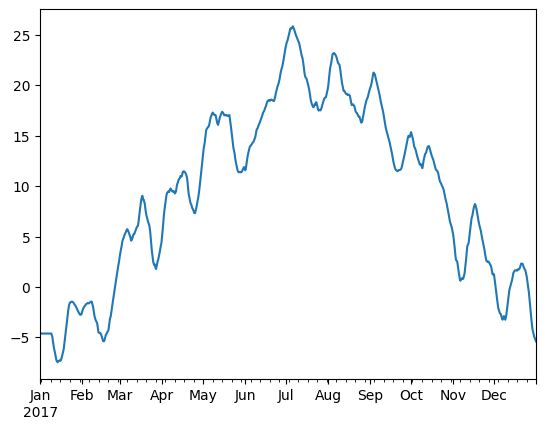

In [208]:
df_heat.Temp_mean.plot()

In [210]:
df_heat['Temp_supply_SFH100']=df_heat.apply(lambda x: supply_temp(x,dict_design['heatload_dt100'],dict_design['design_temp'],dict_design['T_dsupply_100'],
                                                          dict_design['T_dreturn_100'],dict_design['rad_exp_100']),axis=1)

df_heat['Temp_supply_SFH100_tank']=df_heat.apply(lambda x: supply_temp(x,dict_design['heatload_dt100'],dict_design['design_temp'],dict_design['T_dsupply_100_tank'],
                                                          dict_design['T_dreturn_100_tank'],dict_design['rad_exp_100']),axis=1)


In [211]:
df_heat

,SFH100_kWh,Temp,Temp_mean,Set_T,Temp_supply_SFH100,Temp_supply_SFH100_tank
2017-01-01 00:00:00,5.028,-3.2,-4.616,20,41.922449,45.629240
2017-01-01 01:00:00,4.720,-2.7,-4.616,20,41.922449,45.629240
2017-01-01 02:00:00,4.767,-3.0,-4.616,20,41.922449,45.629240
2017-01-01 03:00:00,4.791,-2.8,-4.616,20,41.922449,45.629240
2017-01-01 04:00:00,4.843,-3.0,-4.616,20,41.922449,45.629240
...,...,...,...,...,...,...
2017-12-31 19:00:00,4.215,-3.3,-5.348,20,42.445728,46.237023
2017-12-31 20:00:00,4.370,-3.8,-5.361,20,42.454996,46.247786
2017-12-31 21:00:00,4.235,-2.7,-5.374,20,42.464262,46.258548
2017-12-31 22:00:00,4.290,-2.9,-5.387,20,42.473528,46.269309


In [212]:
df_hp=pd.read_csv('../Input/HP_data.csv',sep=';')# Temperature in celcius
df_hp.loc[:,'P_el']=df_hp.loc[:,'P_el'].str.replace(',','.').astype(float)
df_hp.loc[:,'COP']=df_hp.loc[:,'COP'].str.replace(',','.').astype(float)
df_hp['P_th']=df_hp.P_el*df_hp.COP

In [213]:
df_heat['HP_T_SFH100_to_use']=df_heat.apply(lambda x: df_hp.T_dist.unique()[find_interval_hp(x.Temp_supply_SFH100,df_hp.T_dist.unique())],axis=1)
df_heat['HP_T_SFH100_tank_to_use']=df_heat.apply(lambda x: df_hp.T_dist.unique()[find_interval_hp(x.Temp_supply_SFH100_tank,df_hp.T_dist.unique())],axis=1)
df_heat['Temp_amb_interval']=df_heat.apply(lambda x: df_hp.T_outside.unique()[find_interval_hp(x.Temp,df_hp.T_outside.unique())],axis=1)

In [218]:
def hp_sizing(dict_design,df_hp):
    '''
    Get the HP rating according to the design temperature (in the interval of the input HP data) and the inlet temperature design.
    It returns the HP rating that provides the closest power to the required, if the HP cannot provide the required heat power, a backup 
    heater is required.
    '''
    desig_temp_hp_data=df_hp.T_outside.unique()[find_interval_hp(dict_design['design_temp'],df_hp.T_outside.unique())]    
    
    hp_100=df_hp.loc[abs(df_hp.loc[(df_hp.T_outside==desig_temp_hp_data)&(df_hp.T_dist==dict_design['T_dsupply_100'])].P_th-dict_design['heatload_dt100']).idxmin(),'HP_rating']
    bu_100=np.ceil(max(0,dict_design['heatload_dt100']-df_hp.loc[(df_hp.HP_rating==hp_100)&(df_hp.T_outside==desig_temp_hp_data)&(df_hp.T_dist==dict_design['T_dsupply_100']),'P_th'].values[0]))
    dict_design.update({'hp_100':hp_100,'bu_100':bu_100})
    return

In [222]:
def get_COP(df,df_hp,dict_design):
    '''
    Calculates the COP for the three house types as well as the hp consumption (electricity, in kW) according to the HP rating, inlet temperature 
    and ambient temperature
    TODO
    -----
    include dt (here 15 minutes)
    '''
    
    df['COP_SFH100']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_100'])&(df_hp.T_dist==x.HP_T_SFH100_to_use)&(df_hp.T_outside==x.Temp_amb_interval),'COP'].values[0],axis=1)
    
    df['COP_SFH100_tank']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_100'])&(df_hp.T_dist==x.HP_T_SFH100_tank_to_use)&(df_hp.T_outside==x.Temp_amb_interval),'COP'].values[0],axis=1)
    
    df['COP_SFH100_DHW']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_100'])&(df_hp.T_dist==55)&(df_hp.T_outside==x.Temp_amb_interval),'COP'].values[0],axis=1)
    
    df['hp_SFH100_el_cons']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_100'])&(df_hp.T_dist==x.HP_T_SFH100_to_use)&(df_hp.T_outside==x.Temp_amb_interval),'P_el'].values[0],axis=1)
    
    df['hp_SFH100_tank_el_cons']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_100'])&(df_hp.T_dist==x.HP_T_SFH100_tank_to_use)&(df_hp.T_outside==x.Temp_amb_interval),'P_el'].values[0],axis=1)
    
    df['hp_SFH100_el_cons_DHW']=df.apply(lambda x: df_hp.loc[(df_hp.HP_rating==dict_design['hp_100'])&(df_hp.T_dist==55)&(df_hp.T_outside==x.Temp_amb_interval),'P_el'].values[0],axis=1)
    return

In [225]:
test_dict

{'26930(Building-902138-CH895237183088)': {'Qs': 0       6.265
  1       5.885
  2       5.946
  3       5.976
  4       6.041
          ...  
  8755    5.242
  8756    5.432
  8757    5.261
  8758    5.330
  8759    6.155
  Name: 26930(Building-902138-CH895237183088):0:Qs(Wh), Length: 8760, dtype: float64,
  'ElectricConsumption': 0       0.113
  1       0.113
  2       0.113
  3       0.113
  4       0.113
          ...  
  8755    0.889
  8756    0.773
  8757    0.966
  8758    0.966
  8759    0.113
  Name: 26930(Building-902138-CH895237183088):ElectricConsumption(kWh), Length: 8760, dtype: float64,
  'SolarPVProduction': 0       0.0
  1       0.0
  2       0.0
  3       0.0
  4       0.0
         ... 
  8755    0.0
  8756    0.0
  8757    0.0
  8758    0.0
  8759    0.0
  Name: 26930(Building-902138-CH895237183088):SolarPVProduction(Wh), Length: 8760, dtype: float64,
  'pv_capacity': {'unit': 'kW', 'Roof': 15.163878464350782, 'Wall': 0.0},
  'consumption_category': 'H4',
  'elec_pr

In [229]:
aux=load_obj('Output/Test')

In [230]:
aux

{'26930(Building-902138-CH895237183088)': {'Qs': 0       6.265
  1       5.885
  2       5.946
  3       5.976
  4       6.041
          ...  
  8755    5.242
  8756    5.432
  8757    5.261
  8758    5.330
  8759    6.155
  Name: 26930(Building-902138-CH895237183088):0:Qs(Wh), Length: 8760, dtype: float64,
  'ElectricConsumption': 0       0.113
  1       0.113
  2       0.113
  3       0.113
  4       0.113
          ...  
  8755    0.889
  8756    0.773
  8757    0.966
  8758    0.966
  8759    0.113
  Name: 26930(Building-902138-CH895237183088):ElectricConsumption(kWh), Length: 8760, dtype: float64,
  'SolarPVProduction': 0       0.0
  1       0.0
  2       0.0
  3       0.0
  4       0.0
         ... 
  8755    0.0
  8756    0.0
  8757    0.0
  8758    0.0
  8759    0.0
  Name: 26930(Building-902138-CH895237183088):SolarPVProduction(Wh), Length: 8760, dtype: float64,
  'pv_capacity': {'unit': 'kW', 'Roof': 15.163878464350782, 'Wall': 0.0},
  'consumption_category': 'H4',
  'elec_pr

In [ ]:
df_heat.reset_index().to_csv('../Input/preprocessed_heat_demand_beers.csv',sep=';')

In [224]:
df_heat

,SFH100_kWh,Temp,Temp_mean,Set_T,Temp_supply_SFH100,Temp_supply_SFH100_tank,HP_T_SFH100_to_use,HP_T_SFH100_tank_to_use,Temp_amb_interval,COP_SFH100,COP_SFH100_tank,COP_SFH100_DHW,hp_SFH100_el_cons,hp_SFH100_tank_el_cons,hp_SFH100_el_cons_DHW
2017-01-01 00:00:00,5.028,-3.2,-4.616,20,41.922449,45.629240,45,50,-2,2.25,2.0,1.7,3.8,4.3,4.6
2017-01-01 01:00:00,4.720,-2.7,-4.616,20,41.922449,45.629240,45,50,-2,2.25,2.0,1.7,3.8,4.3,4.6
2017-01-01 02:00:00,4.767,-3.0,-4.616,20,41.922449,45.629240,45,50,-2,2.25,2.0,1.7,3.8,4.3,4.6
2017-01-01 03:00:00,4.791,-2.8,-4.616,20,41.922449,45.629240,45,50,-2,2.25,2.0,1.7,3.8,4.3,4.6
2017-01-01 04:00:00,4.843,-3.0,-4.616,20,41.922449,45.629240,45,50,-2,2.25,2.0,1.7,3.8,4.3,4.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,4.215,-3.3,-5.348,20,42.445728,46.237023,45,50,-2,2.25,2.0,1.7,3.8,4.3,4.6
2017-12-31 20:00:00,4.370,-3.8,-5.361,20,42.454996,46.247786,45,50,-2,2.25,2.0,1.7,3.8,4.3,4.6
2017-12-31 21:00:00,4.235,-2.7,-5.374,20,42.464262,46.258548,45,50,-2,2.25,2.0,1.7,3.8,4.3,4.6
2017-12-31 22:00:00,4.290,-2.9,-5.387,20,42.473528,46.269309,45,50,-2,2.25,2.0,1.7,3.8,4.3,4.6


In [220]:
hp_sizing(dict_design,df_hp)

In [221]:
dict_design

{'T_dsupply_15_45': 35,
 'T_dreturn_15_45': 30,
 'T_dsupply_100': 50,
 'T_dreturn_100': 40,
 'T_dsupply_15_45_tank': 40,
 'T_dreturn_15_45_tank': 35,
 'T_dsupply_100_tank': 55,
 'T_dreturn_100_tank': 45,
 'rad_exp_15_45': 1.1,
 'rad_exp_100': 1.3,
 'heatload_dt100': np.float64(7.461),
 'design_temp': np.float64(-16.322934368110076),
 'hp_100': np.int64(11),
 'bu_100': np.float64(1.0)}

In [54]:
def find_interval_hp(x, partition):
    '''
    Description
    -----------
    find_interval at which x belongs inside partition. Returns the index i.

    Parameters
    ------
    x: float; numerical value
    partition: array; sequence of numerical values
    Returns
    ------
    i: index; index for which applies
    partition[i] < x < partition[i+1], if such an index exists.
    -1 otherwise
    TODO
    ------
    '''

    for i in range(0, len(partition)):
        if x <= partition[i]:
            return i
    if x >partition[i]:
        return i

In [56]:
def supply_temp(df,heatload,design_temp,T_supply,T_return,rad_exp):
    '''
    Description
    ---------
    Determines the inlet temperature according to the The Reference Framework for System Simulations of the IEA SHC Task 44 / HPP Annex 38
Part B: Buildings and Space Heat Load eq 11 pg 13 of 35. For this the ambient temperature, the set temperature and the design temperatures are needed
    Temperatures in Celsius or Kelvin
    Parameters
    ---------
    df: dataframe; includes ambient and set Temp as well as the heat demand for the SFH
    heatload:
    T_supply:
    T_return:
    rad_exp:
    Returns
    ---------
    Temperature of supply (pd.Series)
    '''
    df_sup=df.copy()
    
    df_sup['Q_herf']=np.heaviside(15-df_sup.Temp_mean,0)*heatload*(df_sup.Set_T-df_sup.Temp_mean)/(df_sup.Set_T-design_temp)

    df_sup['delta_t']=0.5*(T_supply+T_return)-df_sup.Set_T

    df_sup['second']=(df_sup.Q_herf/heatload)**(1/rad_exp)*df_sup.delta_t

    df_sup['third']=df_sup.Q_herf/(2*heatload)*(T_supply-T_return)
    return df_sup.Set_T+df_sup.second+df_sup.third

In [57]:
def return_temp(df,heatload,design_temp,T_supply,T_return,rad_exp):
    '''
    Description
    ---------
    Determines the inlet temperature according to the The Reference Framework for System Simulations of the IEA SHC Task 44 / HPP Annex 38
Part B: Buildings and Space Heat Load eq 11 pg 13 of 35. For this the ambient temperature, the set temperature and the design temperatures are needed
    Temperatures in Celsius or Kelvin
    Parameters
    ---------
    df: dataframe; includes ambient and set Temp as well as the heat demand for the SFH
    heatload:
    T_supply:
    T_return:
    rad_exp:
    Returns
    ---------
    Temperature of return (pd.Series)
    '''
    df_sup=df.copy()
    df_sup['second']=(T_supply-T_return)/2*(df_sup.Set_T-df_sup.Temp_mean)/(df.Set_T-design_temp)
    df_sup['third']=((T_supply+T_return)/2-df_sup.Set_T)*((df_sup.Set_T-df_sup.Temp_mean)/(df.Set_T-design_temp))**(1/rad_exp)
    return df_sup.Set_T-df_sup.second+(df_sup.third)*np.heaviside(15-df_sup.Temp_mean,0)

In [40]:
building='26933(Building-902139-CH503730975261)'
df=pd.DataFrame(test_dict[building]['Qs'])

<Axes: >

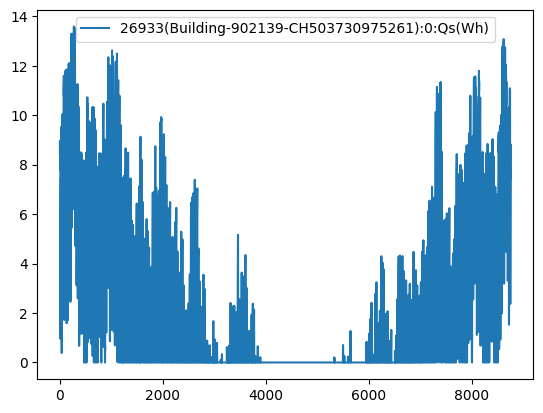

In [41]:
df.plot()

In [36]:
df.sum()/148.56

26933(Building-902139-CH503730975261):0:Qs(Wh)    149.517326
dtype: float64

In [120]:
test_dict[building]

{'Qs': 0       5.028
 1       4.720
 2       4.767
 3       4.791
 4       4.843
         ...  
 8755    4.215
 8756    4.370
 8757    4.235
 8758    4.290
 8759    4.947
 Name: 26934(Building-902141-CH513082523745):0:Qs(Wh), Length: 8760, dtype: float64,
 'ElectricConsumption': 0       0.090
 1       0.090
 2       0.090
 3       0.090
 4       0.090
         ...  
 8755    0.711
 8756    0.618
 8757    0.773
 8758    0.773
 8759    0.090
 Name: 26934(Building-902141-CH513082523745):ElectricConsumption(kWh), Length: 8760, dtype: float64,
 'SolarPVProduction': 0       0.0
 1       0.0
 2       0.0
 3       0.0
 4       0.0
        ... 
 8755    0.0
 8756    0.0
 8757    0.0
 8758    0.0
 8759    0.0
 Name: 26934(Building-902141-CH513082523745):SolarPVProduction(Wh), Length: 8760, dtype: float64,
 'pv_capacity': {'unit': 'kW', 'Roof': 12.663407361382248, 'Wall': 0.0},
 'consumption_category': 'H4',
 'elec_price': 31.544444444444444,
 'temperature': 0      -3.2
 1      -2.7
 2      -3.0


In [121]:
df=pd.DataFrame(test_dict[building]['Qs'])

<Axes: >

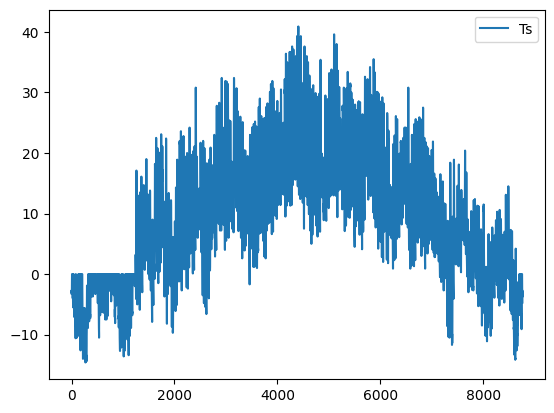

In [152]:
df.plot()

In [151]:
df.sum()

Ts    81953.7
dtype: float64

In [155]:
df=pd.DataFrame(test_dict[building]['Qs'])#already in kWh

In [158]:
df.sum()/140

26934(Building-902141-CH513082523745):0:Qs(Wh)    88.828386
dtype: float64

<Axes: >

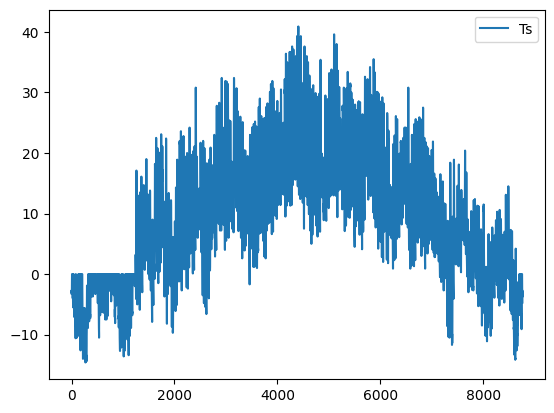

In [124]:
df.plot()

In [143]:
get_design_temperature_hp(df.Ts,pd.DataFrame(test_dict[building]['Qs'])*4)

Design Temperature= -16.322934368110076 °C
The heat load at design ambient temperature for SFH15 is:[29.844]


(np.float64(-16.322934368110076), array([29.844]))

C:\Users\alejandr.penabell\AppData\Local\Temp\ipykernel_4088\4167248808.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(ax[0].get_yticks(),size=normal_size)
C:\Users\alejandr.penabell\AppData\Local\Temp\ipykernel_4088\4167248808.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels((ax[0].get_xticks()/math.pi*8600).astype(int),size=normal_size)
C:\Users\alejandr.penabell\AppData\Local\Temp\ipykernel_4088\4167248808.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(ax[1].get_yticks(),size=normal_size)
C:\Users\alejandr.penabell\AppData\Local\Temp\ipykernel_4088\4167248808.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after 

The fitting function has the form a+b*cos((x+c)*2*pi/max(x))
9.356766612622726+-11.81569904422727*cos((x+-0.10098318368670796)*2)
Design Temperature= -16.322934368110076 °C


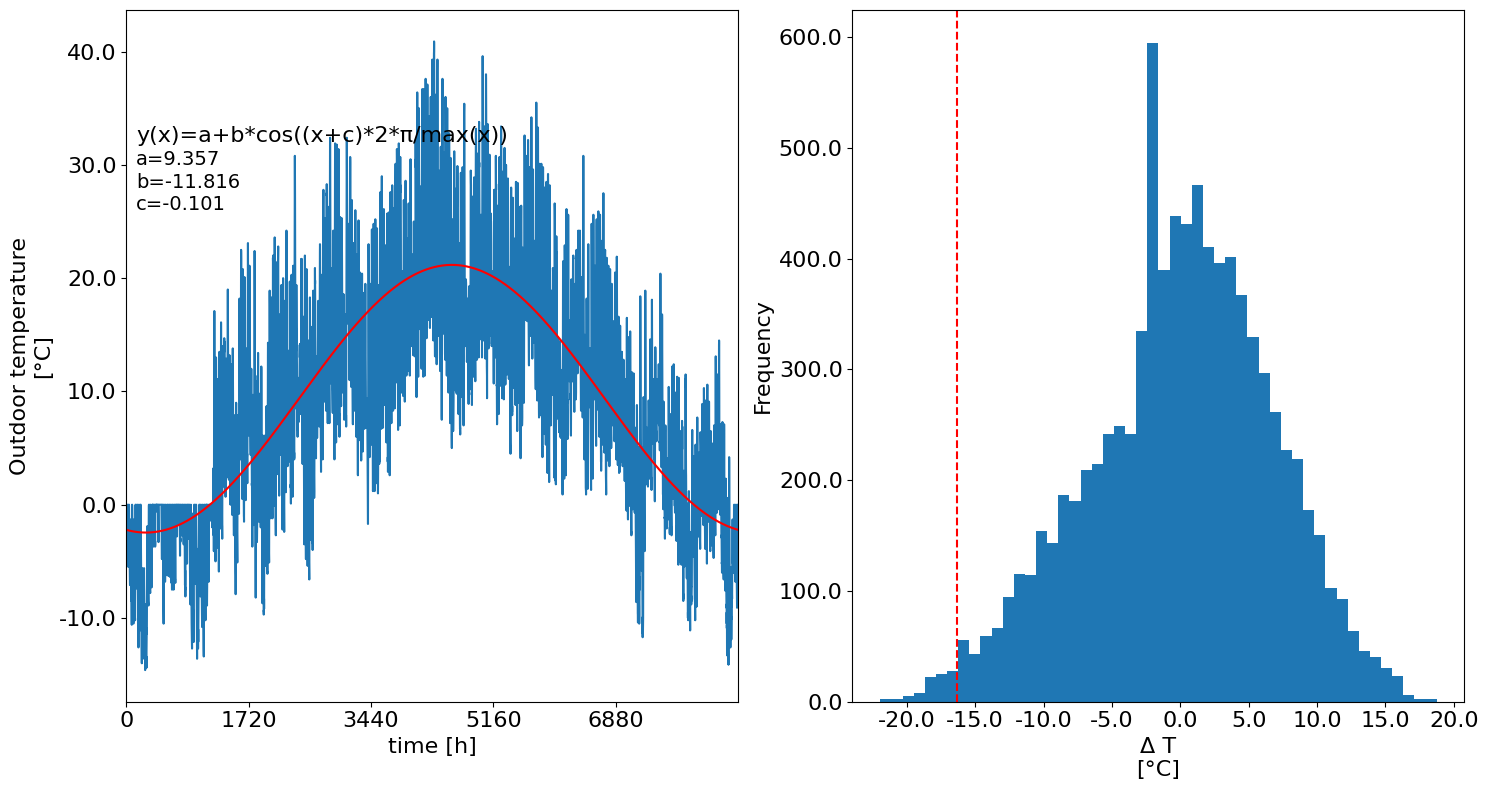

In [127]:
normal_size=16
fig,ax=plt.subplots(1,2,figsize=(15,8))

ax[0].plot(x_data,y_data)
ax[0].plot(x_data,yearly_temps(x_data, *opt_results), 'r-')#The * send the whole array a separated as if a[0],a[1],a[2] were sent
ax[0].set_xlabel('time [h]',size=normal_size)
ax[0].set_ylabel('Outdoor temperature\n[°C]',size=normal_size)
ax[0].set_yticklabels(ax[0].get_yticks(),size=normal_size)
ax[0].xaxis.set_major_locator(plt.MultipleLocator(math.pi/5))
ax[0].set_xlim(0,3.1415)
ax[0].set_xticklabels((ax[0].get_xticks()/math.pi*8600).astype(int),size=normal_size)

#plt.text(-55,2150,'a)',size=normal_size)

ax[0].text(0.05,32,'y(x)=a+b*cos((x+c)*2*π/max(x))',size=normal_size)
ax[0].text(0.05,30,'a={}'.format(opt_results.round(3)[0]),size=normal_size-2)
ax[0].text(0.05,28,'b={}'.format(opt_results.round(3)[1]),size=normal_size-2)
ax[0].text(0.05,26,'c={}'.format(opt_results.round(3)[2]),size=normal_size-2)
#ax.text(0.05,24,'{})'.format(opt_results.round(3)[3]))
#fig.savefig('Geneva_temp_dist.pdf')
print('The fitting function has the form a+b*cos((x+c)*2*pi/max(x))')
print('{}+{}*cos((x+{})*2)'.format(*opt_results))


conf_int=0.99
design_temp=np.quantile(temp_deviation_from_sine_fit,1-conf_int)
print('Design Temperature= {} °C'.format(design_temp))
#plt.text(-20,2150,'b)',size=normal_size)
ax[1].hist(temp_deviation_from_sine_fit,bins=50)
ax[1].axvline(x=design_temp,color='r',linestyle='--')
ax[1].set_xlabel('Δ T\n[°C]',size=normal_size)
ax[1].set_ylabel('Frequency',size=normal_size)
ax[1].set_yticklabels(ax[1].get_yticks(),size=normal_size)
ax[1].set_xticklabels(ax[1].get_xticks(),size=normal_size)
#ax[1].text(-11.2,2000,'Design Temperature= {} °C'.format(design_temp.round(1)),rotation=90,size=normal_size)
plt.tight_layout()
plt.show()
#fig.savefig('outdoor_distribution.pdf')



In [128]:
df_power=pd.DataFrame(test_dict[building]['Qs'])*4

In [ ]:
heat_load_ix=np.arange(-20,20,0.1)

heat_load=(df_power.groupby(df.Ts).mean())


In [131]:
heat_load

,26934(Building-902141-CH513082523745):0:Qs(Wh)
Ts,
-14.6,29.128000
-14.4,28.936000
-14.1,28.609333
-14.0,28.490667
-13.9,29.236000
...,...
39.6,0.000000
39.8,0.000000
40.0,0.000000


In [132]:
heat_load

,26934(Building-902141-CH513082523745):0:Qs(Wh)
Ts,
-14.6,29.128000
-14.4,28.936000
-14.1,28.609333
-14.0,28.490667
-13.9,29.236000
...,...
39.6,0.000000
39.8,0.000000
40.0,0.000000


In [ ]:

heat_load_ix=np.arange(-20,20,0.1)
heat_load=(df_power.groupby(df.Ts).mean())
heat_load=heat_load.loc[heat_load.index<20]
z15 = np.polyfit(heat_load.index, heat_load, 1)

fit_15=heat_load_ix*z15[0]+z15[1]



In [ ]:

heat_load_ix=np.arange(-20,20,0.1)
heat_load=(df_power.groupby(df.Ts).mean())
heat_load=heat_load.loc[heat_load.index<20]
z15 = np.polyfit(heat_load.index, heat_load, 1)

fit_15=heat_load_ix*z15[0]+z15[1]


heatload_dt15=np.round(design_temp*z15[0]+z15[1],3)
print('The heat load at design ambient temperature for SFH15 is:{}'.format(heatload_dt15))



The heat load at design ambient temperature for SFH15 is:[29.844]


<Axes: >

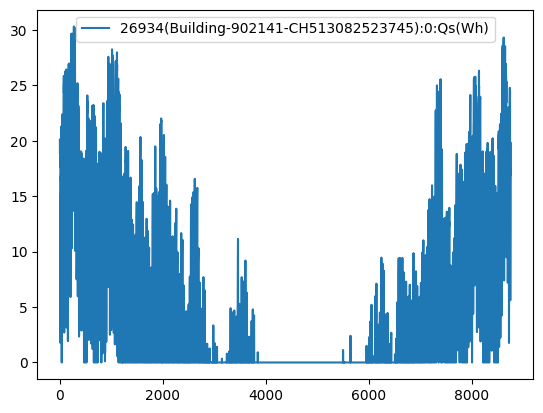

In [148]:
(df_power).plot()

The minimum temperature of the dataset is -14.6 °C
-16.322934368110076


C:\Users\alejandr.penabell\AppData\Local\Temp\ipykernel_4088\498656523.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(heat_load.index,heat_load,'ro',color='g',markersize=2,label='SFH')
C:\Users\alejandr.penabell\AppData\Local\Temp\ipykernel_4088\498656523.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(),size=normal_size)
C:\Users\alejandr.penabell\AppData\Local\Temp\ipykernel_4088\498656523.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(),size=normal_size)


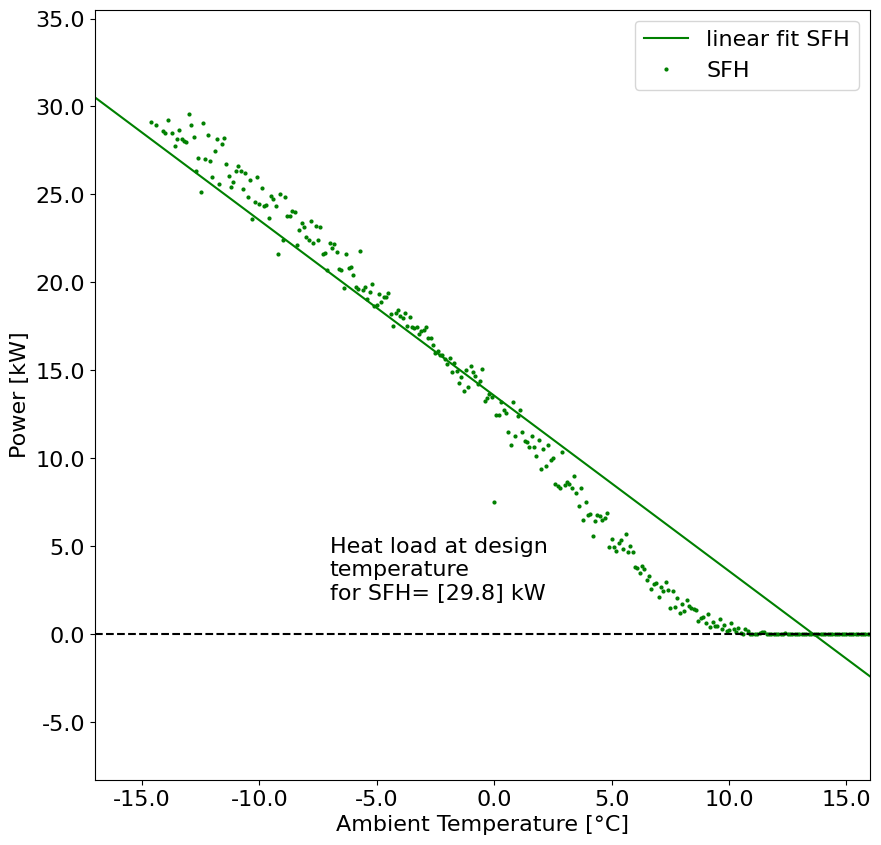

In [141]:



print('The minimum temperature of the dataset is {} °C'.format(df.Ts.min()))

fig,ax=plt.subplots(figsize=(10,10))

ax.plot(heat_load_ix, fit_15,'g-',label='linear fit SFH')

ax.plot(heat_load.index,heat_load,'ro',color='g',markersize=2,label='SFH')


ax.set_xlim(-17,16)
ax.legend( prop={'size': normal_size})
ax.set_yticklabels(ax.get_yticks(),size=normal_size)
ax.set_xticklabels(ax.get_xticks(),size=normal_size)
ax.set_ylabel('Power [kW]',size=normal_size)
ax.set_xlabel('Ambient Temperature [°C]',size=normal_size)
conf_int=0.99
design_temp=np.quantile(temp_deviation_from_sine_fit,1-conf_int)
print(design_temp)
ax.axhline(y=0,color='k',linestyle='--')
ax.text(-7,2,'Heat load at design\ntemperature\nfor SFH= {} kW'.format(heatload_dt15.round(1)),size=normal_size)



plt.show()